In [2]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re



In [3]:
df = pd.read_csv("../enron_1.csv")

In [4]:
# 1. Check for NaNs in the processed text
num_nans = df['final_text'].isnull().sum()
print("NaNs in final_text:", num_nans)

# 2. Check for empty strings (after stripping whitespace)
num_empty = (df['final_text'].str.strip() == '').sum()
print("Empty strings in final_text:", num_empty)


NaNs in final_text: 1
Empty strings in final_text: 0


In [5]:
df = df.dropna(subset=['final_text']) # Drop rows that are NaN
df = df.reset_index(drop=True)


In [6]:
print(df.isnull().sum())


is_spam       0
final_text    0
dtype: int64


## Data Engineering/Extraction

### TF-IDF Vectorization

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,    # limit vocabulary size, 5000 features (these features are the most “important” words or n-grams from our corpus)
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words='english'  # skip common words
)

X_tfidf = tfidf.fit_transform(df['final_text'].fillna(''))
 #feature matrix, the numerical representation of all our documents


TF-IDF extracts each unique word (or n-gram), builds a vocabulary

Builds/returns a vocabulary of all unique words (or n-grams) it learned from your corpus. Above shows only the words that actually appear in the first email, along with their importance scores.

### Inspect / Analyze TF-IDF

In [8]:
vocab = tfidf.get_feature_names_out()
print(len(vocab))        # should be ≤ max_features
print(vocab[:20])        # preview first 20 words

5000
['00' '00 00' '00 10' '00 60' '00 90' '00 million' '00 pm' '000' '000 00'
 '000 000' '000 enron' '000 hpl' '000 mmbtu' '0000' '001' '01' '01 01'
 '01 2000' '01 2001' '01 enron']


In [9]:
# View words specifically 
word_vocab = [w for w in vocab if re.match(r'^[a-zA-Z]+$', w)]
print(f"Words only: {len(word_vocab)}")
print(word_vocab[:50])  # preview first 50 words


Words only: 3439
['aa', 'ab', 'ability', 'able', 'abroad', 'absence', 'absolutely', 'abuse', 'ac', 'academic', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accessory', 'accomplish', 'accordance', 'according', 'accordingly', 'account', 'accountant', 'accounting', 'accuracy', 'accurate', 'achieve', 'achievement', 'acquire', 'acquired', 'acquiring', 'acquisition', 'acre', 'acrobat', 'act', 'action', 'active', 'activity', 'actua', 'actual', 'actually', 'acy', 'ad', 'adam', 'add', 'added', 'adding', 'addition', 'additiona', 'additional', 'additionally']


Above checks TF-IDF vocabulary

In [10]:
i = 0  # first email
df_single = pd.DataFrame(X_tfidf[i].T.todense(), index=tfidf.get_feature_names_out(), columns=["tfidf"])
print(df_single[df_single.tfidf > 0]) #Filter to only non-zero TF-IDF scores


            tfidf
04       0.035158
05       0.071669
07       0.038055
08       0.036016
08 2000  0.058075
...           ...
update   0.038464
utility  0.091919
volume   0.037544
waiting  0.047460
working  0.035259

[149 rows x 1 columns]


In [11]:
sparsity = 1.0 - (X_tfidf.count_nonzero() / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 98.63%


Out of all the entries in your TF-IDF matrix, 98.62% are zeros.
Only 1.38% of the cells have a non-zero TF-IDF value.

### top words by TF-IDF score

In [12]:
# tfidf (TfidfVectorizer) and X_tfidf assumed present
feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# average TF-IDF in spam vs non-spam
avg_spam = tfidf_df[df['is_spam'] == 1].mean(axis=0)
avg_nonspam = tfidf_df[df['is_spam'] == 0].mean(axis=0)

spam_top = avg_spam.sort_values(ascending=False).head(40)
print("Top TF-IDF words in spam (avg):")
print(spam_top)


Top TF-IDF words in spam (avg):
http           0.036147
com            0.033903
email          0.021875
www            0.020625
company        0.019221
click          0.018814
http www       0.017135
price          0.016159
software       0.015285
money          0.015048
offer          0.015029
free           0.014884
best           0.014865
site           0.014767
save           0.014642
time           0.014352
online         0.014208
want           0.013690
order          0.013216
info           0.013026
day            0.012880
new            0.012586
business       0.012561
information    0.012507
net            0.012393
like           0.012305
account        0.012030
000            0.011856
product        0.011829
mail           0.011767
need           0.011578
website        0.011016
life           0.010767
visit          0.010753
stop           0.010666
adobe          0.010446
make           0.010431
message        0.010377
hello          0.009895
viagra         0.009871
dtype: f

## Additional features (to test)

- Common keywords
- word count
- char count 
- Avg word length
- number frequency 
- punctuation frequency 

### Exploring common phishing keywords

In [13]:
key_words = [
    'click', 'login', 'transfer', 'free', 'win', 'payment', 'transaction', 'transfer', 'money', 'tax', 'receipt',
    'urgent', 'verify account', 'act', 'confirm', 'view', 'unusual', "limited", 
    "new", "message", "required", "action", "document", "verification","special", "offer"

]

# Dictionary to hold keyword summary
kw_summary = {}

# Loop through each keyword
for w in key_words:
    # Detect presence of keyword (boolean Series, not added to df)
    has_kw = df['final_text'].str.contains(r'\b' + re.escape(w) + r'\b', regex=True, case=False)
    
    # Compute metrics
    tp = ((has_kw) & (df['is_spam'] == 1)).sum()  # spam emails containing keyword
    fp = ((has_kw) & (df['is_spam'] == 0)).sum()  # non-spam emails containing keyword
    in_email = has_kw.sum()                       # total emails containing keyword

    # Store in summary
    kw_summary[w] = {
        'in_email': in_email,
        'spam_hits': tp,
        'nonspam_hits': fp,
        'spam_likelihood': tp / (in_email + 1e-9)
    }

# Convert to DataFrame for viewing
kw_df = pd.DataFrame.from_dict(kw_summary, orient='index').sort_values('spam_likelihood', ascending=False)
kw_df

spam_likelihood_dict = kw_df['spam_likelihood'].to_dict()

def keyword_likelihood_score(text):
    score = 0
    for kw, likelihood in spam_likelihood_dict.items():
        if re.search(r'\b' + re.escape(kw) + r'\b', text, flags=re.IGNORECASE):
            score += likelihood
    return score

# Add feature to DF
df['kw_score'] = df['final_text'].apply(keyword_likelihood_score)



In [14]:
df.sample(10)

,is_spam,final_text,kw_score
4333,1,best financial internet ! need make money fast...,0.827532
17926,1,real replica watch next brand available likewi...,0.000000
26932,1,edge mastic scrapbook get prescription one loc...,0.000000
24140,1,website traffic effective & intelligent e g 3 ...,3.801276
1712,0,98 - 1534 215 k 3 / 2000 good 3 / 1 - 3 / 1 si...,0.000000
15632,0,"bill , wanted let know ' going take couple wee...",0.332465
1537,0,encina tru ups . meter vance new march avg . 4...,0.458011
74,0,- - - - - - - - - - - - - - - - - - - - - - fo...,0.000000
26533,1,tried contact earlier flnanclng home lower rat...,0.000000
13945,0,"louise : fyi . one would hope , statistically ...",0.332465


In [15]:
df['word_count'] = df['final_text'].apply(lambda x: len(str(x).split()))
df['unique_word_count'] = df['final_text'].apply(lambda x: len(set(str(x).split())))

def count_numbers(text):
    return len(re.findall(r'\d+', text))

df['num_count'] = df['final_text'].apply(count_numbers)


import string
import re

def repeated_punct_symbols(text, min_repeat=2):
    text = str(text)
    # Define suspicious symbols (can adjust based on dataset)
    suspicious_chars = string.punctuation  # includes all standard punctuation
    # You could also customize like: "!$%#*?@"
    
    # Regex: any character in suspicious_chars repeated min_repeat or more times
    pattern = r'([{}])\1{{{}}}'.format(re.escape(suspicious_chars), min_repeat - 1)
    
    # Return 1 if any repeated pattern found, else 0
    return int(bool(re.search(pattern, text)))




In [16]:
df.sample(10)

,is_spam,final_text,kw_score,word_count,unique_word_count,num_count
19529,1,"satisfy elder impose fine grain money , shall ...",1.437772,166,103,31
23362,1,invited amazing new site hosting ton free stuf...,1.438195,78,59,5
13693,0,"louise , please find attached description asse...",0.000000,52,38,0
18116,1,' troubling ? 1981 weather websmaps bruce lee,0.000000,8,8,1
4695,1,get u n ive rsi plom acal 1 number : 206 - 424...,0.421388,160,135,4
2835,0,"stacey , new deal , 158220 , missing 10 , 000 ...",0.458011,128,48,16
23851,1,hoodia gordonii nature way telling - - - dont ...,1.702972,389,215,8
28224,1,good day visit new name - brand oem software s...,1.250478,207,84,38
27623,1,know actually make money google ? anyone easy ...,0.827532,174,168,1
14093,1,"place charge $ 20 , charge $ 5 . quite differe...",0.000000,53,37,3


### Unsual/rare word feature 
- signal for unusual or suspicious words

In [17]:
from collections import Counter

all_words = " ".join(df['final_text']).split()  # Use your cleaned text column

# Count the frequency of each word
word_counts = Counter(all_words)

# Define and store rare words (appearing < n times across your entire corpus) 
rare_words = {w for w, c in word_counts.items() if c < 4}

# Function to count rare words per email
def count_rare_words(text):
    return sum(1 for w in str(text).split() if w in rare_words)

df['rare_word_count'] = df['final_text'].apply(count_rare_words)


In [18]:
df['num_urls'] = df['final_text'].str.count(r'http[s]?://')
df['num_emails'] = df['final_text'].str.count(r'\b[\w.-]+@[\w.-]+\.\w+\b')

threshold = 4
df['many_rare_words'] = (df['rare_word_count'] >= threshold).astype(int)


In [19]:
df.sample(10)

,is_spam,final_text,kw_score,word_count,unique_word_count,num_count,rare_word_count,num_urls,num_emails,many_rare_words
27717,1,"sayýn kamu kurum kuruluþlarý , özel sektör bel...",0.000000,77,63,2,45,0,0,1
3918,1,athens extramural pancake puddingstone amphibi...,0.000000,38,38,0,1,0,0,0
15435,1,sa 4 7 ro % ordoering onl 4 ine tooday ! viasi...,0.000000,88,86,4,10,0,0,1
19978,1,new clalls softtabs = lnstant rockhard erectlo...,1.068250,42,38,6,0,0,0,0
24261,1,legal teen xxx hardcore 4 free boy gauge surpr...,2.895588,143,97,4,0,0,0,0
13294,0,"dear louise , thank using register . com submi...",1.180799,437,157,5,0,0,0,0
25893,1,sa ; 7 _ 0 % ord . ering onl / ine ` day ! vi ...,0.000000,145,142,2,5,0,0,1
4278,1,hello name anthony lewis . seeking possible li...,1.475252,136,86,8,3,0,0,0
673,0,"well , jury still communicating ranking . ques...",0.000000,20,18,0,1,0,0,0
14845,1,"dance street , ago . paint wait put heavy . su...",0.000000,90,62,0,0,0,0,0


## Training

In [20]:
numeric_features = ['kw_score', 'word_count', 'unique_word_count','rare_word_count']
X_numeric = df[numeric_features]  # shape: (n_samples, n_numeric_features)

In [21]:
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MaxAbsScaler

# Convert numeric features to sparse
X_numeric_sparse = csr_matrix(X_numeric.values)

# Scale numeric features
scaler = MaxAbsScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_sparse)

# Combine TF-IDF (sparse) and numeric (now scaled & sparse)
X_combined = hstack([X_tfidf, X_numeric_scaled])

print(X_combined.shape)  # (n_samples, n_tfidf_features + n_numeric_features)


(29367, 5004)


## Logistic Regression

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

y = df['is_spam']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Logistic Regression
model = LogisticRegression(
    solver='saga', 
    max_iter=5000, 
    penalty='l2',
)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9805924412665986

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3095
           1       0.97      0.99      0.98      2779

    accuracy                           0.98      5874
   macro avg       0.98      0.98      0.98      5874
weighted avg       0.98      0.98      0.98      5874



In [23]:
train_set = accuracy_score(y_train, model.predict(X_train))
test_set = accuracy_score(y_test, model.predict(X_test))

print("Train accuracy:", train_set)
print("Test set acc:",  test_set)

Train accuracy: 0.9888903077512451
Test set acc: 0.9805924412665986


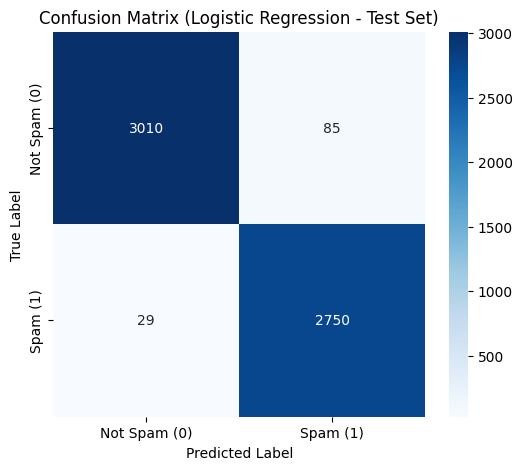

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Spam (0)', 'Spam (1)'],  
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (Logistic Regression - Test Set)')     
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Cross-Validation Check

In [25]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_combined, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))


Cross-validation accuracies: [0.98195438 0.98484848 0.9819513  0.98263239 0.98161076]
Mean accuracy: 0.9826 ± 0.0012


## Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9713993871297242

Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3095
           1       0.97      0.97      0.97      2779

    accuracy                           0.97      5874
   macro avg       0.97      0.97      0.97      5874
weighted avg       0.97      0.97      0.97      5874



In [27]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(nb_model, X_combined, y, cv=cv, scoring='accuracy')

print("Naive Bayes cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

Naive Bayes cross-val accuracies: [0.97139939 0.97361253 0.97309722 0.97360804 0.9720756 ]
Mean accuracy: 0.9728 ± 0.0009


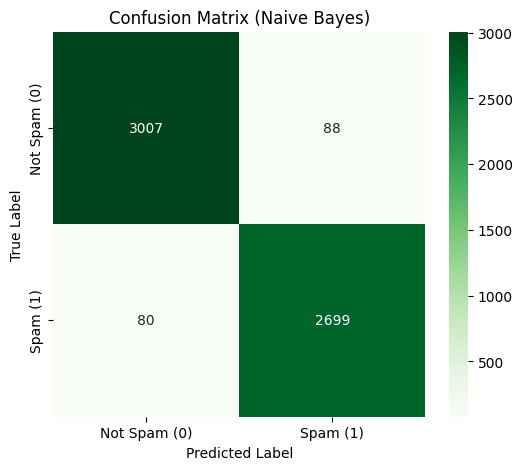

In [28]:
cm_nb = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Not Spam (0)', 'Spam (1)'],
    yticklabels=['Not Spam (0)', 'Spam (1)']
)
plt.title('Confusion Matrix (Naive Bayes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM Model

In [29]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42)

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9831460674157303

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      3095
           1       0.98      0.99      0.98      2779

    accuracy                           0.98      5874
   macro avg       0.98      0.98      0.98      5874
weighted avg       0.98      0.98      0.98      5874



In [30]:
train_set = accuracy_score(y_train, svm_model.predict(X_train))
test_set = accuracy_score(y_test, svm_model.predict(X_test))

print("Train accuracy:", train_set)
print("Test set acc:",  test_set)

Train accuracy: 0.9969778231813732
Test set acc: 0.9831460674157303


In [31]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X_combined, y, cv=cv, scoring='accuracy')

print("SVM cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

SVM cross-val accuracies: [0.98433776 0.98501873 0.98450536 0.98365401 0.98365401]
Mean accuracy: 0.9842 ± 0.0005


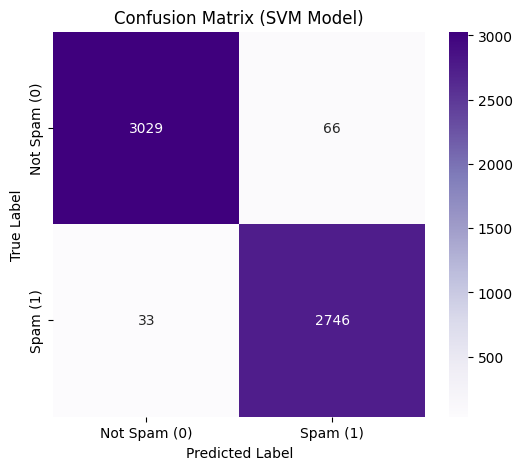

In [32]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fit model
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.9824651004426286

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      3095
           1       0.98      0.99      0.98      2779

    accuracy                           0.98      5874
   macro avg       0.98      0.98      0.98      5874
weighted avg       0.98      0.98      0.98      5874



In [47]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X_combined, y, cv=cv, scoring='accuracy')

print("Naive Bayes cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

Naive Bayes cross-val accuracies: [0.97957099 0.98399728 0.98246211 0.98058914 0.98092968]
Mean accuracy: 0.9815 ± 0.0016


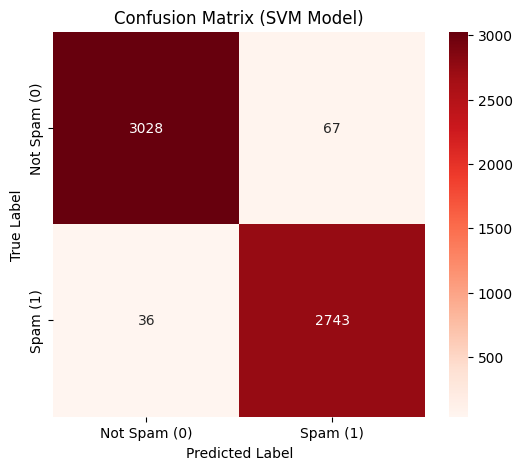

In [36]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Slow comapred to other algorithms

## LGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

lgbm_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,          # -1 = no limit
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_model.fit(X_train, y_train)

y_pred_lgbm = lgbm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 11116, number of negative: 12377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 433356
[LightGBM] [Info] Number of data points in the train set: 23493, number of used features: 4984
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473162 -> initscore=-0.107454
[LightGBM] [Info] Start training from score -0.107454
Accuracy: 0.9839972761321076

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      3095
           1       0.98      0.99      0.98      2779

    accuracy                           0.98      5874
   macro avg       0.98      0.98      0.98      5874
weighted avg       0.98      0.98      0.98      5874



c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lgbm_model, X_combined, y, cv=cv, scoring='accuracy')

print("Naive Bayes cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

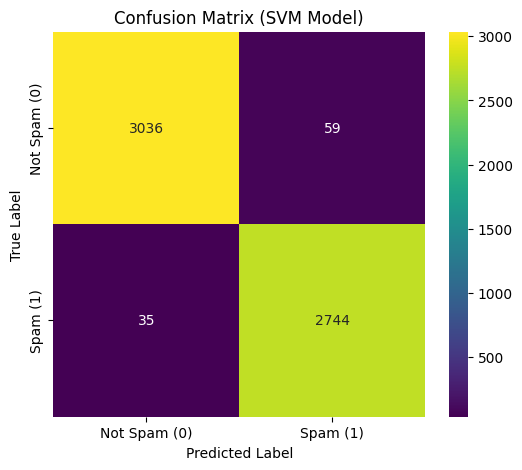

In [49]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()